# Eigentrust Algorithm for Reputation

In [273]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(linewidth=200)
from tabulate import tabulate, SEPARATING_LINE

G = nx.Graph()
G.add_edges_from([(0, 1), (1,6), (1,7), (0,4),(1,8),(0, 2), (0, 3), (0,18),(2, 5), (5,9), (5,10), (5,11), (5,12), (0,13), (0,14), (0,15), (1,16), (2,17), (17,18), (18,14),(18,21),(2,21), (17,19), (17,20), (14,21),(14,2),
                 (6,12),(6,22),(6,23),(6,24),(7,23),(12,25),(12,26),(12,27), (25,28),(25,29),(29,9), (15,3), (3,4), (7,8)])

In [274]:
G = nx.Graph()
G.add_edges_from([(0, 1), (1,6), (1,7), (0,4),(1,8),(0, 2), (0, 3), (0,18),(2, 5), (5,9), (5,10), (5,11), (11,12), (0,13), (0,14), (0,15), (1,16), (2,17), (17,18), (18,14), (17,19), (14,2),
                 (6,12), (15,3), (3,4), (7,8), (10,11), (6,16)])

In [275]:
nodelist = [x for x in range(len(G.nodes))]
print(nodelist)
len(nodelist)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


20

In [276]:
np.set_printoptions()
np.set_printoptions(precision=0)
adjs = nx.adjacency_matrix(G, nodelist=nodelist).todense()
print(adjs.shape)
adjs

(20, 20)


array([[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0,

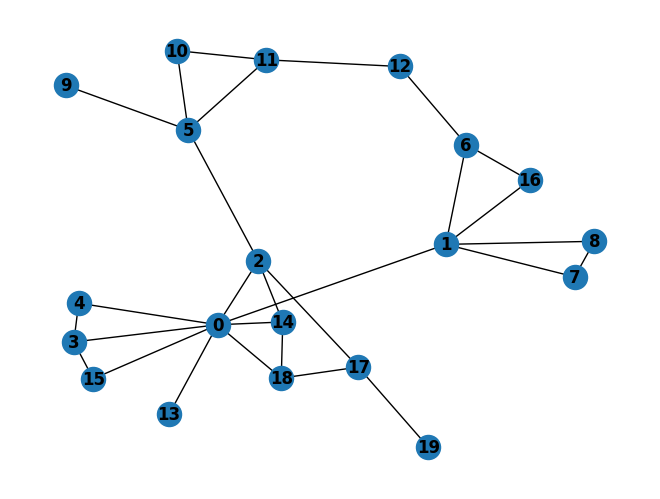

In [277]:
nx.draw(G,pos=nx.spring_layout(G), with_labels=True, font_weight='bold')
plt.savefig("eigentrust.png")

In [278]:
def generate_peer_review():
    np.random.seed(42214)
    rng = np.random.default_rng()
    n, p = 1, 0.68
    s = rng.binomial(n, p, random.randint(0, 20))
    s[s==0]= -1 # this is because it generates numbers either 0 or 1, so zeros are replaced by -1
    return sum(s)

### Local Trust Values

In a distributed environment, peers may still rate each other after each transaction, as in the eBay system.

For example, each time peer $i$ makes a transaction with peer $j$, it may rate the transaction as:
- positive $tr(i, j) = +1$ 

or 

- negative $tr(i, j) = −1$.

Like in the eBay model, we may define a *local trust value* $s_{ij}$ as the sum of the ratings of the individual transactions that peer $i$ has
done with peer $j$: 

$s_{ij} = \sum tr_{ij}$.

The simplest notion of trust is just a log of your own interactions with others that you yourself can keep. So whenever Alice wants to download a file from Bob, and the file turns out to be the Nickelback song you were looking for, Alice keeps a log of “Bob +1” (starting with 0 for Bob if she’s never interacted with him). If the file is white noise, Alice logs “Bob -1”. Alice does the same with her interactions with Charlie and David. The problem is, of course, that this is just Alice’s own opinion, and in a huge peer-to-peer network it would take a long time for Alice to build strong opinions on enough others.

In [279]:
# Generate random transactions and rates and calculate local trust values
loc_tru = np.zeros(adjs.shape)

def gene_local_trust(adjs):
    for i in range(adjs.shape[0]):
        for j in range(adjs.shape[1]):
            if (adjs[i][j]== 1):
                loc_tru[i][j]=generate_peer_review()
    return loc_tru

In [280]:
from pathlib import Path
list(Path('.').glob('*.npy'))

[PosixPath('example.npy'),
 PosixPath('example_with_nan.npy'),
 PosixPath('soctrust.npy')]

## Random generate local trust values

In [281]:
#s = gene_local_trust(adjs)
#with open('example.npy', 'wb') as f:
    #np.save(f, s)
with open('example.npy', 'rb') as f:
    s = np.load(f)
#s=adjs
s

array([[ 0.,  5.,  1.,  3., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  6.,  3.,  0.,  0.,  4.,  0.],
       [ 6.,  0.,  0.,  0.,  0.,  0.,  0., 11.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,  0., -3.,  0.,  0.],
       [ 5.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 8.,  0.,  0., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  8., 16.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  

$
\begin{bmatrix}
0 &  5 &  1 &  3 & 11 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  1 &  6 &  3 &  0 &  0 &  4 &  0\\
6 &  0 &  0 &  0 &  0 &  0 &  0 & 11 &  4 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  8 &  0 &  0 &  0\\
0 &  0 &  0 &  0 &  0 &  3 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  5 &  0 &  0 & -3 &  0 &  0\\
5 &  0 &  0 &  0 &  3 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0\\
8 &  0 &  0 & 11 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0\\
0 &  0 &  8 &  0 &  0 &  0 &  0 &  0 &  0 &  8 & 16 &  5 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0\\
0 &  5 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  5 &  0 &  0 &  0 &  2 &  0 &  0 &  0\\
0 &  8 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0\\
0 &  5 &  0 &  0 &  0 &  0 &  0 &  3 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0\\
0 &  0 &  0 &  0 &  0 &  4 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0\\
0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  1 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0\\
0 &  0 &  0 &  0 &  0 & 13 &  0 &  0 &  0 &  0 &  3 &  0 & -1 &  0 &  0 &  0 &  0 &  0 &  0 &  0\\
0 &  0 &  0 &  0 &  0 &  0 & -1 &  0 &  0 &  0 &  0 &  7 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0\\
3 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0\\
4 &  0 &  1 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  7 &  0\\
-3 &  0 &  0 &  1 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0\\
0 &  1 &  0 &  0 &  0 &  0 &  6 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0\\
0 &  0 &  3 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  3\\
3 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  4 &  0 &  0 &  7 &  0 &  0\\
 0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  0 &  7 &  0 &  0
\end{bmatrix}
$

In [282]:
s_sum = np.sum(s, axis=1, keepdims=True)
node_size = s_sum.flatten().tolist()
max(node_size), min(node_size)

(37.0, -2.0)

In [283]:
# sub total in rows
np.sum(s, axis=1, keepdims=True)

array([[34.],
       [29.],
       [ 5.],
       [ 8.],
       [19.],
       [37.],
       [12.],
       [ 8.],
       [ 8.],
       [ 4.],
       [ 1.],
       [15.],
       [ 6.],
       [ 3.],
       [12.],
       [-2.],
       [ 7.],
       [ 6.],
       [14.],
       [ 7.]])

In [284]:
#sub totals in columns
np.sum(s, axis=0, keepdims=True)

array([[26., 24., 13., 15., 14., 20.,  5., 14.,  4.,  8., 19., 13.,  4.,  1., 15.,  3., 10., 11., 11.,  3.]])

In [285]:
node_degree = np.sum(adjs,axis=1, keepdims=True).T
node_agg_local_trust = np.sum(s, axis=0, keepdims=True)
avg_trust = node_agg_local_trust / node_degree

node_degree = node_degree.flatten().tolist()
node_agg_local_trust = node_agg_local_trust.flatten().tolist()
avg_trust = avg_trust.flatten().tolist()

node_degree.insert(0,'node_degree')
node_agg_local_trust.insert(0,'node_agg_local_trust')
avg_trust.insert(0,'trust_per_degree')

table=[node_degree, node_agg_local_trust,avg_trust, SEPARATING_LINE]
print(tabulate(table,headers=['metric'] + nodelist, floatfmt=".0f"))

metric                  0    1    2    3    4    5    6    7    8    9    10    11    12    13    14    15    16    17    18    19
--------------------  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
node_degree             8    5    4    3    2    4    3    2    2    1     2     3     2     1     3     2     2     3     3     1
node_agg_local_trust   26   24   13   15   14   20    5   14    4    8    19    13     4     1    15     3    10    11    11     3
trust_per_degree        3    5    3    5    7    5    2    7    2    8    10     4     2     1     5     2     5     4     4     3
--------------------  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----


`node_agg_local_trust` is the sum of each collum, which is the trust given to a peer by whoever is connected to it.

### Normalizing *Local Trust Values*

In order to aggregate local trust values, it is necessary to normalize them in some manner. Otherwise, malicious peers can assign arbitrarily high local trust values to other malicious peers, and arbitrarily low local trust values to good peers, easily subverting the system. 

We define a *normalized local trust value*, $c_{ij}$ , as follows:

$c_{ij} = \dfrac{max(s_{ij},0)}{\sum_{j} max(s_{ij},0)}$

**This ensures that all values will be between 0 and 1.**

In [286]:
c = np.zeros(s.shape)
np.maximum(s,c)

array([[ 0.,  5.,  1.,  3., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  6.,  3.,  0.,  0.,  4.,  0.],
       [ 6.,  0.,  0.,  0.,  0.,  0.,  0., 11.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 8.,  0.,  0., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  8., 16.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  

In [287]:
np.sum(np.maximum(s,c), axis=0, keepdims=True)

array([[29., 24., 13., 15., 14., 20.,  6., 14.,  4.,  8., 19., 13.,  5.,  1., 15.,  3., 10., 14., 11.,  3.]])

In [288]:
def make_c():
    c = np.zeros(s.shape)
    s_max = np.maximum(s,c)
    s_sum_max = np.sum(s_max, axis=1, keepdims=True)
    float_formatter = "{:.2f}".format
    np.set_printoptions(formatter={'float_kind':float_formatter})
    #c = np.where(s_max == 0, 0, s_max / s_sum_max)
    with np.errstate(divide='ignore',invalid='ignore'):
        c =  s_max / s_sum_max
    return c
    

In [289]:
c = make_c()
c

array([[0.00, 0.15, 0.03, 0.09, 0.32, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.03, 0.18, 0.09, 0.00, 0.00, 0.12, 0.00],
       [0.21, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.38, 0.14, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.28, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.38, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.62, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.62, 0.00, 0.00, 0.00, 0.38, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.42, 0.00, 0.00, 0.58, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.22, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.22, 0.43, 0.14, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.42, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.42, 0.00, 0.00, 0.00, 0.17, 0.00, 0.00, 0.00],
       [0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,

In [290]:
# Notice that every i (line) it is normalized over j
np.sum(c, axis=1, keepdims=True)

array([[1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00]])

### Interpretation of $c_{ij}$

It is values are relative (no absolute interpretation) and it somehow conveys the reputation of $j$ in the eyes of peer $i$.

There are some drawbacks to normalizing in this manner:
- For one, the normalized trust values do not distinguish between a peer with whom peer $i$ did not interact and a peer with whom peer $i$ has had poor experience. 
- Also, these $c_{ij}$ values are relative, and there is no absolute interpretation. That is, if $c_{ij} = c_{ik}$, we know that peer $j$ has the same reputation as peer $k$ in the eyes of peer $i$, but we don’t know if both of them are very reputable, or if both of them are mediocre.

Notice that when $\sum_{j} max(s_{ij}) = 0$, then $c_{ij}$ is undefined, `nan`. This issue is addressed in Section `Practical Issues`.

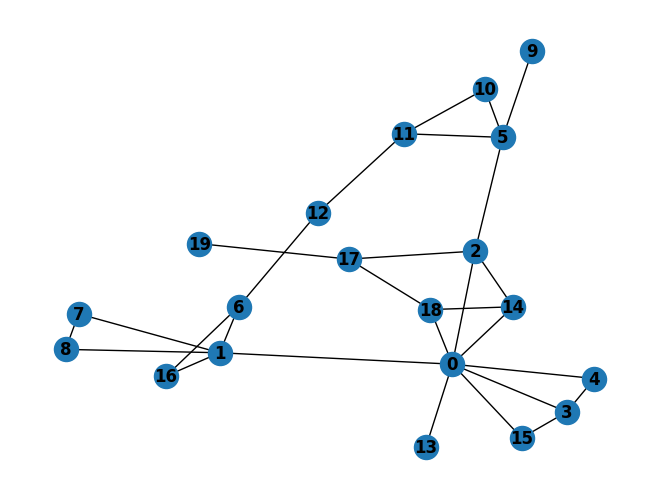

In [291]:
#nx.draw(G,pos=nx.spring_layout(G), with_labels=True, font_weight='bold', node_size=ns)
nx.draw(G,pos=nx.spring_layout(G), with_labels=True, font_weight='bold')

In [292]:
def tabula_trust_values(line):
    adja = adjs[line].tolist()
    adja.insert(0,'adjacency')
    adja.append(sum(adjs[line]))
    
    newli = s[line].tolist()
    newli.insert(0,'local trust value')
    newli.append(sum(s[line]))
    
    newci = c[line].tolist()
    newci.insert(0,'normalized local trust value')
    newci.append(sum(c[line]))
    
    table=[adja, newli,newci,SEPARATING_LINE]
    print(tabulate(table, headers=['metric'] + nodelist + ['sum'], floatfmt=".2f"))

In [293]:
tabula_trust_values(line=0)

metric                           0     1     2     3      4     5     6     7     8     9    10    11    12    13    14    15    16    17    18    19    sum
----------------------------  ----  ----  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----
adjacency                     0.00  1.00  1.00  1.00   1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  1.00  1.00  0.00  0.00  1.00  0.00   8.00
local trust value             0.00  5.00  1.00  3.00  11.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  6.00  3.00  0.00  0.00  4.00  0.00  34.00
normalized local trust value  0.00  0.15  0.03  0.09   0.32  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.03  0.18  0.09  0.00  0.00  0.12  0.00   1.00
----------------------------  ----  ----  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----


Again, notice that the normalized trust values do not distinguish between a peer with whom peer $i$ did not interact and a peer with whom peer $i$ has had poor experience. As you can see above, negative local trust values are normalized to zero, due to the rule $max(s_{ij},0)$.

In [294]:
tabula_trust_values(line=14)

metric                           0     1     2     3     4     5     6     7     8     9    10    11    12    13    14    15    16    17    18    19    sum
----------------------------  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----
adjacency                     1.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00   3.00
local trust value             4.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  7.00  0.00  12.00
normalized local trust value  0.33  0.00  0.08  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.58  0.00   1.00
----------------------------  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----


In [295]:
tabula_trust_values(line=2)

metric                           0     1     2     3     4     5     6     7     8     9    10    11    12    13    14    15    16     17    18    19    sum
----------------------------  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----  ----  ----  -----
adjacency                     1.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00   1.00  0.00  0.00   4.00
local trust value             0.00  0.00  0.00  0.00  0.00  3.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  5.00  0.00  0.00  -3.00  0.00  0.00   5.00
normalized local trust value  0.00  0.00  0.00  0.00  0.00  0.38  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.62  0.00  0.00   0.00  0.00  0.00   1.00
----------------------------  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----  ----  ----  -----


In [296]:
tabula_trust_values(line=15)

metric                            0     1     2     3     4     5     6     7     8     9    10    11    12    13    14    15    16    17    18    19    sum
----------------------------  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----
adjacency                      1.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2.00
local trust value             -3.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  -2.00
normalized local trust value   0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   1.00
----------------------------  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----


### The problem:

The problem is, of course, that this is just Alice’s own opinion, and in a huge peer-to-peer network it would take a long time for Alice to build strong opinions on enough others.

### Aggregating *Local Trust Values*

A natural way to do this in a distributed environment is for peer $i$ to ask its acquaintances about their opinions about other peers. 

It would make sense to weight their opinions by the trust peer $i$ places in them:

$t_{ik} = \sum_{j} c_{ij}c_{jk}$

where $t_{ik}$ represents the trust that peer $i$ places in peer $k$ based on asking his friends.

Back to Alice's example. So instead, **why doesn’t she also ask those peers that she already trusts, for their opinion on their friends?** So if Alice now wants to download from David, who she’s never interacted with before, she checks with Bob (who she’s logged as +5) and with Charlie (who she’s logged as +15) for their opinions of David, and Alice weights Charlie’s opinion of David higher than Bob’s, because she trusts him more than Bob based on her own interactions.


In [297]:
t = np.zeros(c.shape)
for i in range(c.shape[0]):
    for k in range(c.shape[0]):
        for j in range(c.shape[0]):
            t[i][k] += c[i][j] * c[j][k]
t

array([[0.34, 0.00, 0.01, 0.28, 0.03, 0.01, 0.00, 0.06, 0.02, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.04, 0.06, 0.10, 0.00],
       [0.00, 0.54, 0.01, 0.02, 0.07, 0.00, 0.24, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.04, 0.02, 0.00, 0.00, 0.02, 0.00],
       [0.21, 0.00, 0.13, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.08, 0.16, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.36, 0.00],
       [0.16, 0.09, 0.02, 0.27, 0.20, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.02, 0.11, 0.06, 0.00, 0.00, 0.07, 0.00],
       [0.36, 0.06, 0.01, 0.04, 0.35, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.07, 0.04, 0.00, 0.00, 0.05, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.41, 0.00, 0.00, 0.00, 0.00, 0.03, 0.43, 0.00, 0.00, 0.14, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.09, 0.02, 0.00, 0.00, 0.00, 0.00, 0.14, 0.16, 0.06, 0.00, 0.00, 0.42, 0.00, 0.00, 0.00, 0.00, 0.11, 0.00, 0.00, 0.00],
       [0.21, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.38, 0.14, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,

In [298]:
np.sum(t, axis=1, keepdims=True)

array([[1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00],
       [1.00]])

In [299]:
def tabula_aggregate_trust_values(line):
    adja = adjs[line].tolist()
    adja.insert(0,'adjacency')
    adja.append(sum(adjs[line]))
    
    newli = s[line].tolist()
    newli.insert(0,'local trust value')
    newli.append(sum(s[line]))
    
    newci = c[line].tolist()
    newci.insert(0,'normalized local trust value')
    newci.append(sum(c[line]))
    
    agg = t[line].tolist()
    agg.insert(0,'aggregated local trust value')
    agg.append(sum(t[line]))
    
    table=[adja, newli,newci,agg, SEPARATING_LINE]
    print(tabulate(table, headers=['metric'] + nodelist + ['agg'], floatfmt=".2f"))

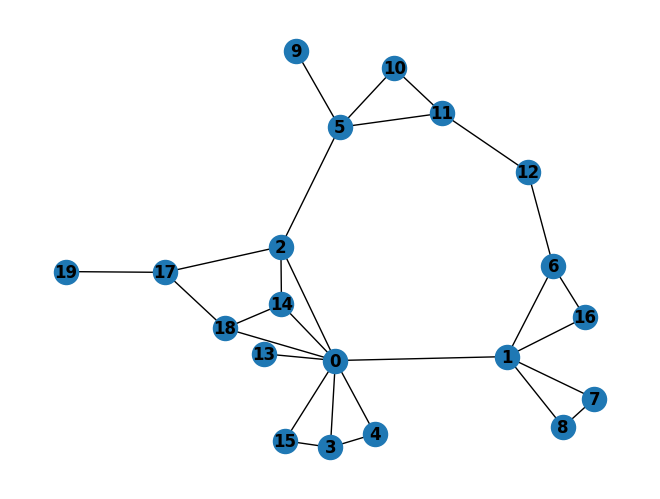

In [300]:
nx.draw(G,pos=nx.spring_layout(G), with_labels=True, font_weight='bold')

In [301]:
tabula_aggregate_trust_values(0)

metric                           0     1     2     3      4     5     6     7     8     9    10    11    12    13    14    15    16    17    18    19    agg
----------------------------  ----  ----  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----
adjacency                     0.00  1.00  1.00  1.00   1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  1.00  1.00  0.00  0.00  1.00  0.00   8.00
local trust value             0.00  5.00  1.00  3.00  11.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  6.00  3.00  0.00  0.00  4.00  0.00  34.00
normalized local trust value  0.00  0.15  0.03  0.09   0.32  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.03  0.18  0.09  0.00  0.00  0.12  0.00   1.00
aggregated local trust value  0.34  0.00  0.01  0.28   0.03  0.01  0.00  0.06  0.02  0.00  0.00  0.00  0.00  0.00  0.05  0.00  0.04  0.06  0.10  0.00   1.00
----------------------------  ----  ----  ----  ----  ----

Interpretation: $t_{ik}$ represents the trust that peer $i$ places in peer $k$. However, this trust is an aggregation of the trust of the direct peers of $i$ places on $k$. 

In other words, this is based on opinions of $i$'s friends about their friends, factored on $i$'s opinion.

In [302]:
tabula_aggregate_trust_values(1)

metric                           0     1     2     3     4     5     6      7     8     9    10    11    12    13    14    15    16    17    18    19    agg
----------------------------  ----  ----  ----  ----  ----  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----
adjacency                     1.00  0.00  0.00  0.00  0.00  0.00  1.00   1.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00   5.00
local trust value             6.00  0.00  0.00  0.00  0.00  0.00  0.00  11.00  4.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  8.00  0.00  0.00  0.00  29.00
normalized local trust value  0.21  0.00  0.00  0.00  0.00  0.00  0.00   0.38  0.14  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.28  0.00  0.00  0.00   1.00
aggregated local trust value  0.00  0.54  0.01  0.02  0.07  0.00  0.24   0.05  0.00  0.00  0.00  0.00  0.00  0.01  0.04  0.02  0.00  0.00  0.02  0.00   1.00
----------------------------  ----  ----  ----  ----  ----

In [303]:
tabula_aggregate_trust_values(5)

metric                           0     1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    agg
----------------------------  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----
adjacency                     0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00   1.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   4.00
local trust value             0.00  0.00  8.00  0.00  0.00  0.00  0.00  0.00  0.00  8.00  16.00  5.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  37.00
normalized local trust value  0.00  0.00  0.22  0.00  0.00  0.00  0.00  0.00  0.00  0.22   0.43  0.14  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   1.00
aggregated local trust value  0.00  0.00  0.00  0.00  0.00  0.41  0.00  0.00  0.00  0.00   0.03  0.43  0.00  0.00  0.14  0.00  0.00  0.00  0.00  0.00   1.00
----------------------------  ----  ----  ----  ----  ----

In [304]:
tabula_aggregate_trust_values(11)

metric                           0     1     2     3     4      5     6     7     8     9    10    11     12    13    14    15    16    17    18    19    agg
----------------------------  ----  ----  ----  ----  ----  -----  ----  ----  ----  ----  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  -----
adjacency                     0.00  0.00  0.00  0.00  0.00   1.00  0.00  0.00  0.00  0.00  1.00  0.00   1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   3.00
local trust value             0.00  0.00  0.00  0.00  0.00  13.00  0.00  0.00  0.00  0.00  3.00  0.00  -1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  15.00
normalized local trust value  0.00  0.00  0.00  0.00  0.00   0.81  0.00  0.00  0.00  0.00  0.19  0.00   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   1.00
aggregated local trust value  0.00  0.00  0.18  0.00  0.00   0.00  0.00  0.00  0.00  0.18  0.35  0.30   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   1.00
----------------------------  ----  ----  ----  ----

In [305]:
#np.sum(t, axis=1, keepdims=True)

We can write $t_{ik} = \sum_{j} c_{ij}c_{jk}$ in matrix notation.

If we define $C$ to be the matrix $[c_{ij}]$ and $\overrightarrow{t_{i}}$ to be the vector containing the values $t_{ik}$, then $\overrightarrow{t_{i}} = C^T \overrightarrow{c_{i}}$. (Note that $\sum_{j} t_{ij} = 1$ as desired)

This is a useful way to have each peer gain a view of the network that is wider than his own experience.

#### Remark:

#### $t_{ik}$ is the value that $i$'s acquaintances places on $k$ weight by how much trust $i$ places on each acquaintance.

#### $\overrightarrow{t_{i}}$ is the **vector** containing the reputation of $k$ that arrives on $i$ by the transmission from its acquaintances.

In [306]:
t[0], sum(t[0])

(array([0.34, 0.00, 0.01, 0.28, 0.03, 0.01, 0.00, 0.06, 0.02, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.04, 0.06, 0.10, 0.00]),
 1.0000000000000002)

In [307]:
np.dot(c.T,c[0]) == t[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True])

$\overrightarrow{t_{i}} = C^T \overrightarrow{c_{i}}$

In [308]:
# vetor t[0]
np.dot(c.T,c[0])

array([0.34, 0.00, 0.01, 0.28, 0.03, 0.01, 0.00, 0.06, 0.02, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.04, 0.06, 0.10, 0.00])

However, the trust values stored by peer $i$ still reflect only the experience of peer $i$ and his acquantainces. 

In order to get a wider view, peer $i$ may wish to ask his friends’ friends $\overrightarrow{t_{i}} = (C^T)^2 \overrightarrow{c_{i}}$

If he continues in this manner, $\overrightarrow{t_{i}} = (C^T)^n \overrightarrow{c_{i}}$, he will have a complete view of the network after $n = $large iterations (under the assumptions that C is irreducible and aperiodic.

Fortunately, if $n$ is large, the trust vector $\overrightarrow{t_{i}}$ will converge to the same vector for every peer $i$. Namely, it will converge to the left principal eigenvector of $C$. In other words,$\overrightarrow{t}$ is a global trust vector in this model. Its elements, $t_j$ , quantify how much trust the system as a whole places peer $j$.

#### Probabilistic Interpretation
It is useful to note that there exists a straightforward probabilistic interpretation of this method, similar to the *Random Surfer model* of [L. Page, S. Brin, R. Motwani, and T. Winograd. The
PageRank Citation Ranking: Bringing Order to the Web. Technical report, Stanford Digital Library Technologies Project, 1998.]. If an agent were searching for reputable peers, it can crawl
the network using the following rule: at each peer $i$, it will crawl to peer $j$ with probability $c_{ij}$ . After crawling for a while in this manner, the agent is more likely to be at reputable peers than unreputable peers. The stationary distribution of the Markov chain defined by the normalized local trust matrix C is our global trust vector $\overrightarrow{t}$.

### Basic EigenTrust

$\overrightarrow{e}$ to be the $m$-vector representing a uniform probability distribution over all $m$ peers, $e_i = 1/m$.

In [309]:
#e = adjs/np.sum(adjs, axis=1, keepdims=True)
#e = adjs/np.sum(adjs)
#np.sum(e, axis=1, keepdims=True).T
#e[0].shape

In [310]:
# this is the distribution, 1 / len(nodes)
e = np.ones((len(nodelist)))/len(nodelist)
e.shape

(20,)

In [311]:
e

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [312]:
c[0]

array([0.00, 0.15, 0.03, 0.09, 0.32, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.03, 0.18, 0.09, 0.00, 0.00, 0.12, 0.00])

In [313]:
def basic_eigen(initial_vec):
    counter = 0
    rep = initial_vec
    epsilon = 0.0005
    while True:
        t_vec = np.dot(c.T,rep)
        theta = np.abs(t_vec - rep)
        rep = t_vec
        if ((theta < epsilon).all()):
            break
        if counter >= 2000: 
            break
        counter += 1
    return dict(t_vec=t_vec, counter=counter)

In [314]:
for i in range(len(nodelist)):
    print(basic_eigen(c[i]),'\n')

{'t_vec': array([0.11, 0.05, 0.07, 0.05, 0.05, 0.14, 0.01, 0.02, 0.01, 0.03, 0.08, 0.11, 0.01, 0.00, 0.08, 0.01, 0.02, 0.06, 0.06, 0.03]), 'counter': 39} 

{'t_vec': array([0.11, 0.05, 0.07, 0.05, 0.05, 0.14, 0.01, 0.02, 0.01, 0.03, 0.08, 0.11, 0.01, 0.00, 0.08, 0.01, 0.02, 0.06, 0.06, 0.03]), 'counter': 30} 

{'t_vec': array([0.10, 0.05, 0.07, 0.05, 0.05, 0.15, 0.01, 0.02, 0.01, 0.03, 0.08, 0.11, 0.01, 0.00, 0.08, 0.01, 0.02, 0.06, 0.06, 0.03]), 'counter': 37} 

{'t_vec': array([0.11, 0.05, 0.07, 0.05, 0.05, 0.14, 0.01, 0.02, 0.01, 0.03, 0.08, 0.11, 0.01, 0.00, 0.08, 0.01, 0.02, 0.06, 0.06, 0.03]), 'counter': 41} 

{'t_vec': array([0.11, 0.05, 0.07, 0.05, 0.05, 0.14, 0.01, 0.02, 0.01, 0.03, 0.08, 0.11, 0.01, 0.00, 0.08, 0.01, 0.02, 0.06, 0.06, 0.03]), 'counter': 41} 

{'t_vec': array([0.10, 0.05, 0.07, 0.05, 0.05, 0.15, 0.01, 0.02, 0.01, 0.03, 0.09, 0.11, 0.01, 0.00, 0.08, 0.01, 0.01, 0.06, 0.06, 0.03]), 'counter': 38} 

{'t_vec': array([0.10, 0.05, 0.07, 0.05, 0.05, 0.15, 0.01, 0.02,

Above the proof that, if $n$ is large, the trust vector $\overrightarrow{t_{i}}$ will converge to the same vector for every peer $i$. Namely, it will converge to the left principal eigenvector of $C$. 

In other words,$\overrightarrow{t}$ is a global trust vector in this model. Its elements, $t_j$ , quantify how much trust the system as a whole places peer $j$.

In [315]:
te = basic_eigen(e)
te

{'t_vec': array([0.11, 0.05, 0.07, 0.05, 0.05, 0.15, 0.01, 0.02, 0.01, 0.03, 0.08, 0.11, 0.01, 0.00, 0.08, 0.01, 0.02, 0.06, 0.06, 0.03]),
 'counter': 23}

(In Section 4.2, we said we wish to compute $\overrightarrow{t_{i}} = (C^T)^n \overrightarrow{c_{i}}$, where $\overrightarrow{c_{i}}$ is the normalized local trust vector of some peer $i$. 

However, since they both converge to the principal left eigenvector of $C$, we may use $\overrightarrow{e}$ instead.)

In [316]:
def tabula_eigentrust_values(eigenvector):
    node_degree = np.sum(adjs,axis=1, keepdims=True).T
    node_agg_local_trust = np.sum(s, axis=0, keepdims=True)
    avg_trust = node_agg_local_trust / node_degree

    node_degree = node_degree.flatten().tolist()
    node_agg_local_trust = node_agg_local_trust.flatten().tolist()
    avg_trust = avg_trust.flatten().tolist()
    eig = eigenvector.tolist()

    node_degree.insert(0,'node_degree')
    node_agg_local_trust.insert(0,'node_agg_local_trust')
    avg_trust.insert(0,'trust_per_degree')
    eig.insert(0,'eigenvector trust value')

    table=[node_degree, node_agg_local_trust,avg_trust, eig, SEPARATING_LINE]
    print(tabulate(table,headers=['metric'] + nodelist, floatfmt=".2f"))
        
    #eig = eigenvector.tolist()
    #eig.insert(0,'eigenvector trust value')
    #eig.append(np.sum(eigenvector))
    
    #table=[eig]
    #print(tabulate(table, headers=['metric'] + nodelist + ['agg'], floatfmt=".2f"))

In [317]:
tabula_eigentrust_values(te['t_vec'])

metric                       0      1      2      3      4      5     6      7     8     9     10     11    12    13     14    15     16     17     18    19
-----------------------  -----  -----  -----  -----  -----  -----  ----  -----  ----  ----  -----  -----  ----  ----  -----  ----  -----  -----  -----  ----
node_degree               8.00   5.00   4.00   3.00   2.00   4.00  3.00   2.00  2.00  1.00   2.00   3.00  2.00  1.00   3.00  2.00   2.00   3.00   3.00  1.00
node_agg_local_trust     26.00  24.00  13.00  15.00  14.00  20.00  5.00  14.00  4.00  8.00  19.00  13.00  4.00  1.00  15.00  3.00  10.00  11.00  11.00  3.00
trust_per_degree          3.25   4.80   3.25   5.00   7.00   5.00  1.67   7.00  2.00  8.00   9.50   4.33  2.00  1.00   5.00  1.50   5.00   3.67   3.67  3.00
eigenvector trust value   0.11   0.05   0.07   0.05   0.05   0.15  0.01   0.02  0.01  0.03   0.08   0.11  0.01  0.00   0.08  0.01   0.02   0.06   0.06  0.03
-----------------------  -----  -----  -----  -----  -----

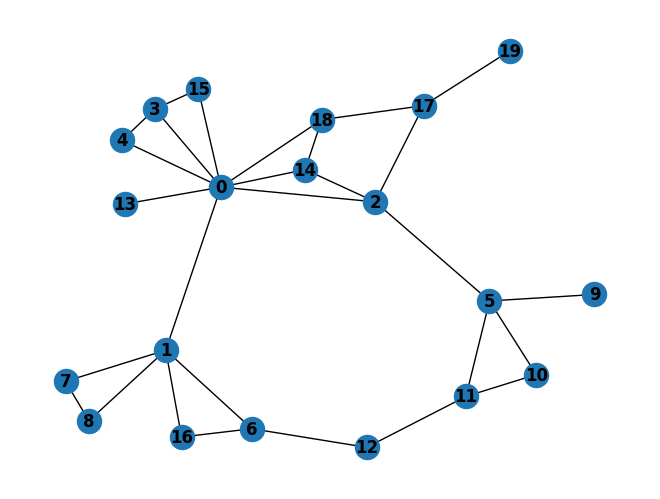

In [53]:
nx.draw(G,pos=nx.spring_layout(G), with_labels=True, font_weight='bold')

Fortunately, if $n$ is large, the trust vector $\overrightarrow{t_{i}}$ will converge to the same vector for every peer $i$. Namely, it will converge to the left principal eigenvector of $C$. In other words,$\overrightarrow{t}$ is a global trust vector in this model. Its elements, $t_j$ , quantify how much trust **"The System"** as a whole places peer $j$.

In Eigentrust, the global reputation of each peer $i$ is given by the local trust values assigned to peer $i$ by other peers, weighted by the global reputations of the assigning peers.

### Practical Issues

There are three practical issues that are not addressed by this simple algorithm: 
- a priori notions of trust, 
- inactive peers, 
- and malicious collectives.


**A priori notions of trust**. Often, there are some peers in the network that are known to be trustworthy. For example, the first few peers to join a network are often known to be trustworthy, since the designers and early users of a P2P network are likely to have less motivation to destroy the network they built. It would be useful to incorporate such notions of trust in a natural and seamless manner. We do this by defining some distribution $\overrightarrow{p}$ over pre-trusted peers.

For example, if some set of peers $P$ are known to be trusted, we may define $p_i = \dfrac{1}{|P|}$ if $i ∈ P$, and $p_i = 0$ otherwise. We use this distribution $\overrightarrow{p}$ in three ways. First of all, in the presence of malicious peers, $\overrightarrow{t} = (C^T)^n \overrightarrow{p}$ will generally converge faster than $\overrightarrow{t} = (C^T)^n \overrightarrow{e}$, so we use $\overrightarrow{p}$ as our start vector.

**Inactive Peers**. If peer $i$ doesn’t download from anybody else, or if it assigns a zero score to all other peers, $c_{ij}$ from Equation $s_{ij} = sat(i, j) − unsat(i, j)$ will be undefined. In this case, we set $c_{ij} = p_j$ . 

So we redefine $c_{ij}$ as:

$
c_{ij}=
\begin{cases}
\dfrac{max(s_{ij},0)}{\sum_{j} max(s_{ij},0)} & \quad \text{if $\sum_{j} max(s_{ij},0) \neq 0$ }\\ 
p_j & \quad \text{otherwise}
\end{cases}
$

That is, if peer $i$ doesn’t know anybody, or doesn’t trust anybody, he will choose to trust the pre-trusted peers.

**Malicious Collectives**. In peer-to-peer networks, there is potential for malicious collectives to form. A malicious collective is a group of malicious peers who know each other, who give each other high local trust values and give all other peers low local trust values in an attempt to subvert the system and gain high global trust values.

We address this issue by taking

$\overrightarrow{t}^{(k+1)} = (1-a) C^T \overrightarrow{t}^{(k)} + a\overrightarrow{p}$ 

where $a$ is some constant less than 1.

This is equivalent to setting the opinion vector for all peers to be $\overrightarrow{c_{ij}} = (1-a) C^T \overrightarrow{t}^{(k)} + a\overrightarrow{p}$ , breaking collectives by having each peer place at least some trust in the peers $P$ that are not part of a collective. Probabilistically, this is equivalent to saying that the agent that is crawling the network by the probabilistic model given by $\overrightarrow{t}$ is less likely to get stuck crawling a malicious collective, because at each step, he has a certain probability of crawling to a pre-trusted peer.

It should be emphasized that the pre-trusted peers are essential to this algorithm, as they guarantee convergence and break up malicious collectives. Therefore, the choice of pre-trusted peers is important. In particular, it is important that no pre-trusted peer be a member of a malicious collective. This would compromise the quality of the algorithm. To avoid this, the system may choose a very few number of pre-trusted peers (for example, the designers of the network).

### Modified EigenTrust

Let's define s set of pre-trusted peers:

In [62]:
P = {1}

In [63]:
#nodelist, ["#D2A254" if x in P else "#1f78b4" for x in nodelist]

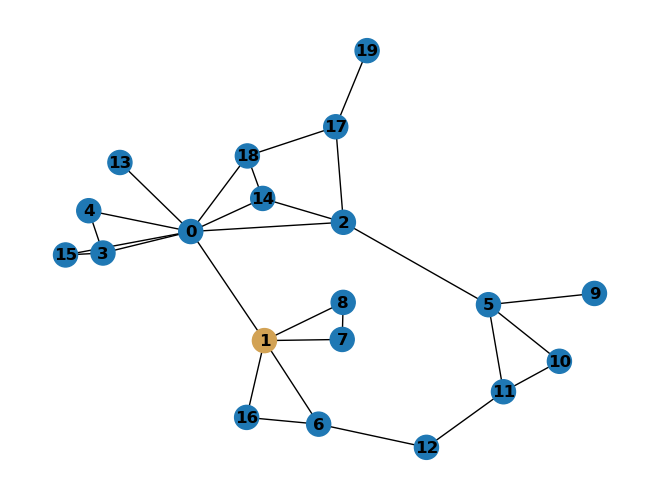

In [64]:
nx.draw(G,pos=nx.spring_layout(G), nodelist=nodelist, with_labels=True, node_color=["#D2A254" if x in P else "#1f78b4" for x in nodelist], font_weight='bold')

In [65]:
p = np.array([1/len(P) if x in P else 0 for x in nodelist])
p

array([0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00])

In [66]:
tp = basic_eigen(p)
tp

{'t_vec': array([0.11, 0.05, 0.07, 0.05, 0.05, 0.14, 0.01, 0.02, 0.01, 0.03, 0.08, 0.11, 0.01, 0.00, 0.08, 0.01, 0.02, 0.06, 0.06, 0.03]),
 'counter': 31}

In [67]:
def modified_eigen(c, P, a = 0.999):    
    def make_c_adj(ce):
        li = np.sum(ce, axis=1, keepdims=True).flatten().tolist()
        inactive = [idx for (idx, value) in enumerate(li) if np.isnan(value)]
        if len(inactive)>0:            
            for i in inactive:
                ce[i] = p
            return ce
        else:
            return ce
                
    nodelist = [x for x in range(c.shape[0])]
    p_vec = np.array([1/len(P) if x in P else 0 for x in nodelist])
    c_adj = make_c_adj(c)
    counter = 0
    rep = p_vec
    epsilon = 0.0005    
    while True:
        t_vec = np.dot(c_adj.T,rep)
        t_vec = (1 - a) * t_vec + a * p_vec
        theta = np.abs(t_vec - rep)
        rep = t_vec
        if ((theta < epsilon).all()):
            break
        if counter >= 200: 
            break
        counter += 1
    return dict(t_vec=t_vec, counter=counter)

$\overrightarrow{t}^{(k+1)} = (1-a) C^T \overrightarrow{t}^{(k)} + a\overrightarrow{p}$ 

where $a$ is some constant less than 1.

In [70]:
tm = modified_eigen(c, P, 0.05)
tm

{'t_vec': array([0.11, 0.17, 0.04, 0.04, 0.05, 0.09, 0.04, 0.07, 0.02, 0.02, 0.05, 0.07, 0.02, 0.00, 0.05, 0.01, 0.05, 0.04, 0.04, 0.02]),
 'counter': 23}

In [54]:
tp

{'t_vec': array([0.10, 0.05, 0.07, 0.05, 0.05, 0.15, 0.01, 0.02, 0.01, 0.03, 0.09, 0.11, 0.01, 0.00, 0.08, 0.01, 0.02, 0.06, 0.06, 0.03]),
 'counter': 25}

In [55]:
te

{'t_vec': array([0.11, 0.05, 0.07, 0.05, 0.05, 0.15, 0.01, 0.02, 0.01, 0.03, 0.08, 0.11, 0.01, 0.00, 0.08, 0.01, 0.02, 0.06, 0.06, 0.03]),
 'counter': 23}

## Distributed EigenTrust

Here, we present an algorithm where all peers in the network cooperate to compute and store the global trust vector, and the computation, storage, and message overhead for each peer are minimal.

In a distributed environment, the first challenge that arises is how to store $C$ and $\overrightarrow{t}$. In previous sections, we suggested that each peer could store its local trust vector $\overrightarrow{c_i}$. Here, we also suggest that each peer store its own global trust value $t_i$.

In fact, each peer can compute its own global trust value:

$t_{i}^{(k+1)} = (1-a)(c_{1i}t_{1}^{(k)} + ... + c_{ni}t_{n}^{(k)}) + ap_i$

Inspection will show that this is the component-wise version of
$\overrightarrow{t}^{(k+1)} = (1−a)C^T \overrightarrow{t}^{(k)}+a\overrightarrow{p}$.


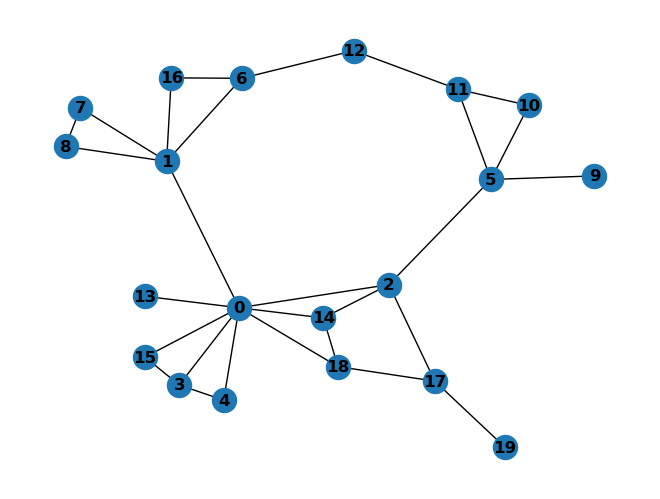

In [57]:
nx.draw(G,pos=nx.spring_layout(G), with_labels=True, font_weight='bold')

In [75]:
#i=12
tabula_aggregate_trust_values(12)

metric                           0     1     2     3     4     5      6     7     8     9    10    11    12    13    14    15    16    17    18    19    agg
----------------------------  ----  ----  ----  ----  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----
adjacency                     0.00  0.00  0.00  0.00  0.00  0.00   1.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2.00
local trust value             0.00  0.00  0.00  0.00  0.00  0.00  -1.00  0.00  0.00  0.00  0.00  7.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   6.00
normalized local trust value  0.00  0.00  0.00  0.00  0.00  0.00   0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   1.00
aggregated local trust value  0.00  0.00  0.00  0.00  0.00  0.81   0.00  0.00  0.00  0.00  0.19  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   1.00
----------------------------  ----  ----  ----  ----  ----

#### $A_i$: set of peers which have downloaded files from peer $i$. These guys may have an opinion about $i$, but $i$ still do not know it.

In [54]:
def A():
    A=dict()
    for i in range(c.shape[0]):    
        li = c[i].flatten().tolist()
        A[i]=[idx for (idx, value) in enumerate(li) if value>0]
    return A
A()

{0: [1, 2, 3, 4, 13, 14, 15, 18],
 1: [0, 7, 8, 16],
 2: [5, 14],
 3: [0, 4],
 4: [0, 3],
 5: [2, 9, 10, 11],
 6: [1, 12, 16],
 7: [1],
 8: [1, 7],
 9: [5],
 10: [11],
 11: [5, 10],
 12: [11],
 13: [0],
 14: [0, 2, 18],
 15: [3],
 16: [1, 6],
 17: [2, 19],
 18: [0, 14, 17],
 19: [17]}

#### $A$ is matrix of entire network, each line shows the interaction between the column peers $j$ with the line peer $i$.

In [55]:
def A_matrix():
    A = adjs*c
    A = np.where(A>0,1,0)
    return A
A_matrix()

array([[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0,

In [76]:
A_matrix()[12]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

#### $B_i$: set of peers from which peer $i$ has downloaded files, so peer $i$ might have opinions about all of them, but they still do not know it.

In [59]:
def B():
    B=dict()
    for i in range(c.shape[0]):    
        li = c.T[i].flatten().tolist()
        B[i]=[idx for (idx, value) in enumerate(li) if value>0]
    return B
B()

{0: [1, 3, 4, 13, 14, 18],
 1: [0, 6, 7, 8, 16],
 2: [0, 5, 14, 17],
 3: [0, 4, 15],
 4: [0, 3],
 5: [2, 9, 11],
 6: [16],
 7: [1, 8],
 8: [1],
 9: [5],
 10: [5, 11],
 11: [5, 10, 12],
 12: [6],
 13: [0],
 14: [0, 2, 18],
 15: [0],
 16: [1, 6],
 17: [18, 19],
 18: [0, 14],
 19: [17]}

#### B is a matrix of the entire network, whcih relates the relation of peer $i$ with those peers $j$ that he may have an opinion

In [77]:
def B_matrix():
    B = adjs*c.T
    B = np.where(B>0,1,0)
    return B
B_matrix()[12]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### Pre-trusted Peers

Only the pre-trusted peers need to know their $p_i$. This means that pre-trusted peers may remain anonymous; nobody else needs to know that they are pre-trusted. Therefore, the pretrusted peers maintain anonymity as pre-trusted peers.

In [61]:
P, p

({0, 6, 11},
 array([0.33, 0.00, 0.00, 0.00, 0.00, 0.00, 0.33, 0.00, 0.00, 0.00, 0.00, 0.33, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]))

### Algorithm:

#### Important assumption

- Each peer store its local trust vector $\overrightarrow{c_i}$. 
- Each peer store its own global trust value $t_i$.

Each peer $i$ do: 

1. Query all peers $j ∈ A_i$ for $t^{(0)}_j = p_j$ ;
   
   Filtre todos os amigos $j$ que conhecem $i$ e considere $t^{(0)}_j = p_j$

In [406]:
ti = np.zeros(p.shape)
ci = np.zeros(c.shape)
ci

array([[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,

In [407]:
a = 0.5
i = 0

In [408]:
A_matrix()[i], A()[i]

(array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0]),
 [1, 2, 3, 4, 13, 14, 15, 18])

In [409]:
for j in A()[i]:
    ti[j] = p[j]
ti

array([0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00])

In [410]:
t_old = ti[0]

In [411]:
# repeat

In [412]:
ci[i] = c[0]
ci[i]

array([0.00, 0.15, 0.03, 0.09, 0.32, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.03, 0.18, 0.09, 0.00, 0.00, 0.12, 0.00])

In [413]:
ci.T[i]

array([0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00])

In [414]:
# Compute t^(k+1)
ti[i] = (1 - a) * np.sum(ci.T[i] * ti[i]) + a * p[i]
ti[i]

0.16666666666666666

In [415]:
B_matrix()[i], B()[i]

(array([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]),
 [1, 3, 4, 13, 14, 18])

In [416]:
# Send C_(ij)^(t(k+1)) to all peers j in B[i]
for j in B()[i]:
    
    ci[j][i] = ci[i][j]

In [417]:
delta = np.abs(ti[i]-t_old)
delta

0.16666666666666666

In [418]:
A_matrix()[i], A()[i]

(array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0]),
 [1, 2, 3, 4, 13, 14, 15, 18])

In [420]:
c

array([[0.00, 0.15, 0.03, 0.09, 0.32, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.03, 0.18, 0.09, 0.00, 0.00, 0.12, 0.00],
       [0.21, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.38, 0.14, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.28, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.38, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.62, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.62, 0.00, 0.00, 0.00, 0.38, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.42, 0.00, 0.00, 0.58, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.22, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.22, 0.43, 0.14, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.42, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.42, 0.00, 0.00, 0.00, 0.17, 0.00, 0.00, 0.00],
       [0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,

In [419]:
ci

array([[0.00, 0.15, 0.03, 0.09, 0.32, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.03, 0.18, 0.09, 0.00, 0.00, 0.12, 0.00],
       [0.15, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.09, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.32, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,

In [310]:
# Wait for all peers j in A[i] to return  C_(ji)^(t(k+1))
for j in A()[i]:
    ti[j] = (1 - a) * np.sum(ci.T[j] * ti[j]) + a * p[j]
    ci[i][i] = 

0.20689655172413793 0.0
0.0 0.0
0.625 0.0
0.42105263157894735 0.0
1.0 0.0
0.3333333333333333 0.0
0.0 0.0
0.21428571428571427 0.0


In [ ]:
A[0]*p

In [ ]:
c[0]

In [ ]:
tnew = np.zeros(p.shape)
tnew

In [ ]:
B[0]

In [ ]:
c[0]*B[0]

In [ ]:
cnew = np.zeros(c.shape)
cnew.shape

In [ ]:
cnew[0] = c[0]*B[0]

In [ ]:
cnew[0]

$t_i$ is a vector of the trust each $i$ has of its peers

In [ ]:
t = np.zeros(c.shape)
t # cada i vai calcular seu t

In [ ]:
t= A * p
t
# Only peers j = {0,6, 11} knows their initial score
# each peer compute and store it won version of the GLOBAl TRUST VECTOR

Initially the vector $t$ comes from pre-trusted peers that $i$ is related with.
In the case of peer $i=5$, because it is related to peer $11$, and it happens to be a pre-trusted, then $t^{0}_5$ contains trust only with $11$.

In [ ]:
np.dot(c.T[5], t[5].T) # this is a component wise version of

In [ ]:
tnew = np.dot(c.T, t[5].T)
tnew

In [ ]:
delta = np.abs(tnew[5] - t[5][5])
delta

In [ ]:
B[5]

In [ ]:
c.T[5]

In [ ]:
t[5]

In [ ]:
np.sum(c.T[5] * t[5])

In [ ]:
tnew

In [ ]:
c[2]

In [ ]:
c[9]

In [ ]:
c[11]

In [ ]:
A[5] * c[5]

In [ ]:
B[5] * c.T[5]

Now we transpose the $c_{ij}$ matrix, because the only info peer $i$ has is his trust experience with his direct peers $j$. At this stage $i$ does not know how much his accquaintances think of him.

In [ ]:
c.T[5]

In [ ]:
c.T[5].shape, tj[5].shape

In [ ]:
ti[5] = np.dot(c.T[5],tj[5])
ti[5]

In [ ]:
B[5]

In [ ]:
c[5]

In [ ]:
B[5]*c[5]*ti[5]

In [ ]:
ti[5]

In [ ]:
# to start with
a = 0

Para computar a interação vamos agregar as confianças dos peers que temos confiança, está é a única infomação que cada peer possui, no caso $c.T[5]$ são os peers que 5 tem uma experiencia própria de confiança vezes a confiança de cada um deles.

In [ ]:
for i in range(20):
    np.dot(c.T[i],t.T[i])



In [ ]:
t1[5]

In [ ]:
res = termo1 + termo2
res[5]

Uma vez computado o escore de confiança de meus peers, eu passo para eles. Da mesma forma no final eu também vou receber de meus peers uma nova informação do quanto eles confiam em mim.

In [ ]:
B[5]

In [ ]:
c[5]*res[5]*B[5]

In [ ]:
c[5]*res[5]

In [ ]:
np.dot(c[5],res[5].T)

In most P2P networks, each peer has limited interaction with other peers. There are two benefits to this. First, the computation 
$t_{i}^{(k+1)} = (1-a)(c_{1i}t_{1}^{(k)} + ... + c_{ni}t_{n}^{(k)}) + ap_i$
is not intensive, since most $c_{ji}$ are zero. Second, the number of messages passed is small, since $A_i$ and $B_i$ are small. In the case where a network is full of heavily active peers, we can enforce these benefits by limiting the number of local trust values $c_{ij}$ that each peer can report.

In [ ]:
# Summary
t = A * p
epoch = 0
#print(dict(t_0=t, epoch=epoch))
a = 0

while True:
    if epoch >= 10: 
        break
    epoch += 1
    termo1 = (1-a) * np.dot(c.T,t.T)
    termo2 = a * p
    t = termo1 + termo2
print('Each peer calculates its version of global trust')

print(dict(t_i=t, epoch=epoch))

# New Version

In [ ]:
A()[5], B()[5]

In [ ]:
P

In [ ]:
p

In [ ]:
ti = np.zeros((c.shape))
ti.shape


In [ ]:
a=0.5

In [ ]:
for i in range(20):
    for j in A()[i]:
        ti[i][j] = p[j]
ti

In [ ]:
ci = np.zeros((20,20,20))
for w in range(20):
    ci[w][w] = c[w]
ci[0], ti[0]

In [ ]:
i = 0
ti[i][i] = (1 - a) * np.dot(ci[i][i].T,ti[i]) + a * p[i]
ti[i]

In [ ]:
A()[i], B()[i]

In [ ]:
for j in B()[i]:
    ci[j][i][j] = ci[i][i][j]
    ti[j][i] = ti[i][i]

In [ ]:
w=13
ci[w], ti[w]

In [ ]:
for j in A()[i]:
    ci[i][j][i] = ci[j][j][i]
    ti[i][j] = ti[j][j]

In [ ]:
w=13
ci[w], ti[w]

In [ ]:
# Summary

epoch = 0
for i in range(1):
    print(f'{i=}')
    t_old = (A * p)[0]
    while True:
        if epoch >= 5: 
            break
        epoch += 1
        print(f'\t{epoch=}')
        t_new = np.dot(c.T,t_old.T)
        print(f'\t\t{t_new[0]=}')
        delta = np.abs(t_new[0]-t_old[0])
        print(f'\t\t{delta=}')
        t_old = t_new

In [ ]:
c.T[0]

In [ ]:
A[0] * p

In [ ]:
p

In [ ]:
def distributed_eigen(c, p, a = 0.999):               
    counter = 0
    rep = pi
    t=np.zeros((len(p)))
    for i in range(len(p)):
        t[i] = np.dot(c[:][i].T,rep)
    epsilon = 0.0005    
    while True:
        
        ti = np.dot(ci.T,rep)
        ti = (1 - a) * ti + a * pi
        theta = np.abs(ti - rep)
        rep = ti
        if ((theta < epsilon).all()):
            break
        if counter >= 200: 
            break
        counter += 1
    return dict(t_vec=ti, counter=counter)

In [ ]:
t = np.zeros((len(p)))

In [ ]:
c[:][0]

In [ ]:
c[:][0]*p[0]

In [ ]:
for i in range(len(nodelist)):
    print(distributed_eigen(c[i], p[i], 0),'\n')

In [ ]:
import numpy as np

def distributed_eigentrust(adj_matrix, num_iterations=10, damping_factor=0.85):
    """
    Performs the distributed Eigentrust algorithm on a given adjacency matrix.

    Args:
        adj_matrix (numpy.ndarray): The adjacency matrix of the trust network.
        num_iterations (int): The number of iterations to run the algorithm for. Default is 10.
        damping_factor (float): The damping factor for the PageRank algorithm. Default is 0.85.

    Returns:
        numpy.ndarray: A vector containing the Eigentrust values for each node in the trust network.
    """

    # Get the number of nodes in the trust network
    num_nodes = adj_matrix.shape[0]

    # Initialize the trust vector with equal values for all nodes
    trust_vec = np.ones(num_nodes) / num_nodes

    # Compute the out-degree of each node in the trust network
    out_degree = np.sum(adj_matrix, axis=1)

    # Normalize the adjacency matrix to obtain the transition probability matrix
    trans_prob_matrix = adj_matrix / out_degree[:, np.newaxis]

    # Perform the Eigentrust algorithm for the specified number of iterations
    for i in range(num_iterations):
        # Compute the new trust vector using the PageRank algorithm
        trust_vec = damping_factor * np.matmul(trans_prob_matrix, trust_vec) + \
                    (1 - damping_factor) / num_nodes

        # Normalize the trust vector
        trust_vec /= np.sum(trust_vec)

    return trust_vec


In [ ]:
distributed_eigentrust(adjs)